In [167]:
'''
Author: Esha Sarkar
Content: Discrimination Control Using Deep Neural Network
'''
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels


#------------------Make a modified Dataset with a dot inserted in random images across the training and test dataset
def TransformMNIST (OrigX,OrigY):
    SelectedImages = np.random.choice(int(OrigX.shape[0]),int(OrigX.shape[0]/2),replace=False) #Choose random images to insert sensitive information

    SubX = OrigX[SelectedImages]
    SubX[:,729] = 1
    
    #Uncomment the following 4 lines if you want the flower as sensitive feature
    SubX[:,700] = 1
    SubX[:,702] = 1
    SubX[:,756] = 1
    SubX[:,758] = 1
    
    SubY = OrigY[SelectedImages]
    SenYCol = np.zeros((OrigY.shape[0],2))
    NewY = np.concatenate((OrigY,SenYCol),axis=1)

    for num,i in enumerate(SelectedImages):
        OrigX[i]=SubX[num]
        NewY[i][11]=1
    NewX = OrigX
    for i in range(int(OrigX.shape[0])):
        if i not in SelectedImages:
            NewY[i][10]=1
    return (SelectedImages, NewX,NewY)

s,XTrainPrime, YTrainPrime = TransformMNIST(XTrain,YTrain)
_,XTestPrime, YTestPrime = TransformMNIST(XTest,YTest)
#These are our dataset for the rest of the project


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### How a transformed image looks like

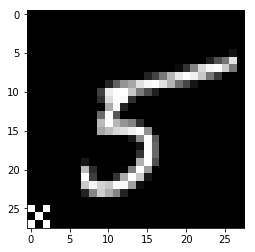

(27500,)


In [168]:
n=s[0]
X=XTrainPrime[n]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()

### Training information:
Each type of optimization followed will have three cell numbers as follows:
    <br>Cell no. A: it defines the parameters
    <br>Cell no. B: it performs the optimization
    <br>Cell no. C: it shows how successful the encoder and classifier have been

In [172]:
#1A
'''Simplest Architecture:
    This just has one layer for encoder and one layer for classifier
    There are no constraints on how good the generated images are and how well it is getting classified 

'''
XTrial = XTrainPrime[:10]
YTrial = YTrainPrime[:10]
alpha = (1/16)
SensitiveLabels = YTrial[:,10:12]
    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([300, 784]))
b2 = tf.Variable(tf.random_normal([784]))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
EncImages = tf.nn.tanh(tf.matmul(Hidden1, W2) + b2);
EncoderParameters = [W1,b1,W2,b2]
    
'''---------------------------------------Classifier Training----------------------------------------'''
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 12]))
b4 = tf.Variable(tf.random_normal([12]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters = [W3,b3,W4,b4]
#print (ClassifierParameters)
    
  # Optimization
learning_rateU = 0.0001
learning_rateV = 0.001
learning_rateE = 0.0005
training_epochs = 9
batch_size = 100
display_step = 1
lambda1 = 1
lambda2 = 1
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer[:,:10])
predU = tf.nn.softmax(OutputLayer[:,10:])

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

var = tf.reduce_mean(tf.reduce_mean(EncImages**2,reduction_indices=1))
cost = CostU - (alpha*CostV) + (lambda1*(tf.reduce_mean(EncImages))) + lambda2*(var-1)

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters)
EncoderOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rateE).minimize(-cost,var_list=EncoderParameters)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
#print ("Predictions:", predU.eval(session=sess,feed_dict={x: XTrial, y: YTrial}))

Entering Optimization


In [173]:
#1B
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch,'\n')
    #print (total_batch)
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    print (avg_cost3) 
    
    for i in range(total_batch):
        #print ('i=',i)
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c2 = sess.run([ClassifierOptimizer2, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c1 = sess.run([ClassifierOptimizer1, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch

    print (avg_cost1,avg_cost2,avg_cost3)
    #print (avg_cost3)

    #if (epoch+1) % display_step == 0:

#        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

print ("Optimization Finished!")

Epoch= 0 

0.0180917635831
0.0190820780667 0.0226128040661 0.0180917635831
Epoch= 1 

0.0187169647217
0.0200952876698 0.0188743348555 0.0187169647217
Epoch= 2 

0.019344107888
0.020513938557 0.0170963963595 0.019344107888
Epoch= 3 

0.0195321984725
0.020513938557 0.0151336808638 0.0195321984725
Epoch= 4 

0.0197753802213
0.020513938557 0.0138155096227 0.0197753802213
Epoch= 5 

0.0198161541332
0.020513938557 0.0130380578475 0.0198161541332
Epoch= 6 

0.0198858295787
0.020513938557 0.0117222508517 0.0198858295787
Epoch= 7 

0.0198836031827
0.020513938557 0.0128261384097 0.0198836031827
Epoch= 8 

0.0199972499501
0.020513938557 0.0103531091863 0.0199972499501
Optimization Finished!


In [174]:
#1C
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))





Detection rate of Sensitive features (on Test Data): 0.4996
Accuracy of Utility (on Test Data): 0.6951


As seen above the utility is almost similar to detection of sensitive features

In [175]:
#2A
'''
The architecture is same but there are some added constraints. Now all the encoded images have to have zero mean 
and unit variance. This is done to not saturate the encoder to a constant solution 
'''

XTrial = XTrainPrime[:10]
YTrial = YTrainPrime[:10]
alpha = (1/16)
SensitiveLabels = YTrial[:,10:12]
    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([300, 784],mean=0, stddev=1))
b2 = tf.Variable(tf.random_normal([784],mean=0, stddev=1))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
EncImages = tf.nn.tanh(tf.matmul(Hidden1, W2) + b2);
EncoderParameters = [W1,b1,W2,b2]
    
'''---------------------------------------Classifier Training----------------------------------------'''
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 12],mean=0, stddev=1))
b4 = tf.Variable(tf.random_normal([12],mean=0, stddev=1))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters = [W3,b3,W4,b4]
#print (ClassifierParameters)
    
  # Optimization
learning_rateU = 0.0001
learning_rateV = 0.001
learning_rateE = 0.0005
training_epochs = 20
batch_size = 100
display_step = 1
lambda1 = 1
lambda2 = 1
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer[:,:10])
predU = tf.nn.softmax(OutputLayer[:,10:])

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

var = tf.reduce_mean(tf.reduce_mean(EncImages**2,reduction_indices=1))
cost = CostU - (alpha*CostV) + (lambda1*(tf.reduce_mean(EncImages))) + lambda2*(var-1)

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters)
EncoderOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rateE).minimize(-cost,var_list=EncoderParameters)

sess = tf.Session()
sess.run(tf.global_variables_initializer())




Entering Optimization


In [176]:
#2B
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch,'\n')
    #print (total_batch)
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    print (avg_cost3) 
    
    for i in range(total_batch):
        #print ('i=',i)
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c2 = sess.run([ClassifierOptimizer2, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c1 = sess.run([ClassifierOptimizer1, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch

    print (avg_cost1,avg_cost2,avg_cost3)
    #print (avg_cost3)

    #if (epoch+1) % display_step == 0:

#        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

print ("Optimization Finished!")

Epoch= 0 

0.0237671696056
0.020531838157 0.0245151138306 0.0237671696056
Epoch= 1 

0.0238949966431
0.0200952876698 0.0174955836209 0.0238949966431
Epoch= 2 

0.0198725787076
0.0200952876698 0.0149038418857 0.0198725787076
Epoch= 3 

0.0194187979265
0.020513938557 0.0113098734075 0.0194187979265
Epoch= 4 

0.0197866751931
0.020513938557 0.011628928618 0.0197866751931
Epoch= 5 

0.0198353750055
0.020513938557 0.00878133253618 0.0198353750055
Epoch= 6 

0.0200695419312
0.020513938557 0.00865246079185 0.0200695419312
Epoch= 7 

0.0201010478627
0.020513938557 0.00837304115295 0.0201010478627
Epoch= 8 

0.0201380677657
0.020513938557 0.00819023219022 0.0201380677657
Epoch= 9 

0.0202063369751
0.020513938557 0.00749094963074 0.0202063369751
Epoch= 10 

0.0202320428328
0.020513938557 0.00499846891923 0.0202320428328
Epoch= 11 

0.0204189075123
0.020513938557 0.00544247367165 0.0204189075123
Epoch= 12 

0.0203760840676
0.020513938557 0.00341945734891 0.0203760840676
Epoch= 13 

0.020546552484

In [178]:
#2C
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))





Detection rate of Sensitive features (on Test Data): 0.5
Accuracy of Utility (on Test Data): 0.8877


Although the above modifications from Cell 2 increases utility but the encoded images look like these: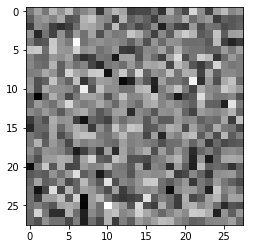
We do not want that. We want to add constraints that the encoded image does not look like a bad QR code


In [402]:
#3A
XTrial = XTrainPrime[:10]
YTrial = YTrainPrime[:10]
alpha = (1)
SensitiveLabels = YTrial[:,10:12]
    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 500], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([500], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([500, 1000],mean=0, stddev=1))
b2 = tf.Variable(tf.random_normal([1000],mean=0, stddev=1))

W3 = tf.Variable(tf.random_normal([1000, 784], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([784], mean=0, stddev = 1))
#W3 = tf.Variable(tf.random_normal([800, 784],mean=0, stddev=1))
#b3 = tf.Variable(tf.random_normal([784],mean=0, stddev=1))

# W1 = tf.Variable(tf.zeros([784, 500]))
# b1 = tf.Variable(tf.zeros([500]))
# W2 = tf.Variable(tf.zeros([500, 1000]))
# b2 = tf.Variable(tf.zeros([1000]))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
Hidden3 = tf.nn.relu(tf.matmul(Hidden1, W2) + b2);
EncImagesTemp = tf.nn.relu(tf.matmul(Hidden3, W3) + b3);

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
EncImages = tf.divide(EncImagesTemp,(c-d))
EncoderParameters = [W1,b1,W2,b2,W3,b3]
    
'''---------------------------------------Classifier Training----------------------------------------'''
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))


W4 = tf.Variable(tf.random_normal([300, 10],mean=0, stddev=1))
b4 = tf.Variable(tf.random_normal([10],mean=0, stddev=1))

W5 = tf.Variable(tf.random_normal([300, 2],mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([2],mean=0, stddev=1))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
OutputLayer2 = tf.matmul(Hidden2, W5) + b5;
ClassifierParameters1 = [W3,b3,W4,b4]
ClassifierParameters2 = [W3,b3,W5,b5]
#print (ClassifierParameters)
    
  # Optimization
learning_rateU = 0.001
learning_rateV = 0.001
learning_rateE1 = 0.001
learning_rateE2 = 0.001
training_epochs = 10
batch_size = 100
display_step = 1
lambda1 = 1
lambda2 = 1
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-5,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-5,1.0)), reduction_indices=1))

var = tf.reduce_mean(tf.reduce_mean(EncImages**2,reduction_indices=1))
cost = CostU - (alpha*CostV)
LookSimilarCost = tf.sqrt(tf.reduce_sum((x-EncImages)**2))

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
EncoderOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateE1).minimize(-cost,var_list=EncoderParameters)
EncoderOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateE2).minimize(-cost,var_list=EncoderParameters)

# ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateU)
# ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateV)
# gvs = ClassifierOptimizer1.compute_gradients(CostU,var_list=ClassifierParameters)
# capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
# CO1 = ClassifierOptimizer1.apply_gradients(capped_gvs)

# gvs = ClassifierOptimizer2.compute_gradients(CostV,var_list=ClassifierParameters)
# capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
# CO2 = ClassifierOptimizer2.apply_gradients(capped_gvs)


# EncoderOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateE1)
# EncoderOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateE2)

# gvs = EncoderOptimizer1.compute_gradients(-cost,var_list=EncoderParameters)
# capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
# EO1 = EncoderOptimizer1.apply_gradients(capped_gvs)

# gvs = EncoderOptimizer2.compute_gradients(LookSimilarCost,var_list=EncoderParameters)
# capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
# EO2 = EncoderOptimizer2.apply_gradients(capped_gvs)

sess = tf.Session()
sess.run(tf.global_variables_initializer())




Entering Optimization


In [403]:
#3B
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    avg_cost4 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch,'\n')
    #print (total_batch)
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer1, cost], feed_dict={x: batch_xs, y: batch_ys})
        _, c4 = sess.run([EncoderOptimizer2, LookSimilarCost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    avg_cost4 += c4 / total_batch
    print (avg_cost3,avg_cost4) 
    
    for i in range(total_batch):
        #print ('i=',i)
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c2 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c1 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch

    print (avg_cost1,avg_cost2)
    #print (avg_cost3)

    #if (epoch+1) % display_step == 0:

#        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

print ("Optimization Finished!")

Epoch= 0 

0.0174238638444 0.155216147683
0.0102569692785 0.00278850577094
Epoch= 1 

0.00771695570512 0.155616732511
0.0102569692785 0.00238004641099
Epoch= 2 

0.00793708194386 0.155714957497
0.0102569692785 0.00230869358236
Epoch= 3 

0.00795237627896 0.155704179244
0.0102569692785 0.00231407859109
Epoch= 4 

0.00794390765103 0.15564964988
0.0102569692785 0.00231156305833
Epoch= 5 

0.00795109315352 0.155637581565
0.0102569692785 0.00230383266102
Epoch= 6 

0.00795086773959 0.155556196733
0.0102569692785 0.00230312174017
Epoch= 7 

0.00795080358332 0.155461578369
0.0102569692785 0.00230289155787
Epoch= 8 

0.00795325192538 0.155674369118
0.0102569692785 0.00230284690857
Epoch= 9 

0.00791001753374 0.155843075839
0.0102569692785 0.00230293794112
Optimization Finished!


In [404]:
#3C
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))





Detection rate of Sensitive features (on Test Data): 0.5
Accuracy of Utility (on Test Data): 0.8754


### New encoded images

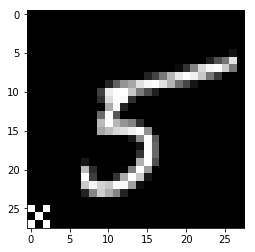

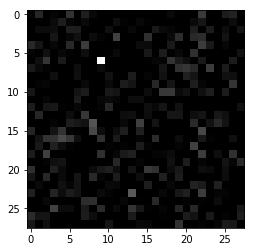

Difference between encoded and original image is 7.31207


In [484]:

n=s[0]
temp1 = XTrainPrime[n].reshape((1,784))
temp2 = temp1.reshape((28,28))
X=EncImages.eval(session=sess,feed_dict={x:temp1})
TempImage = X.reshape((28,28))
plt.imshow(temp2, cmap='gray')
plt.show()
plt.imshow(TempImage, cmap='gray')
plt.show()
distance = np.sqrt(np.sum((X-temp1)**2))
print ("Difference between encoded and original image is", distance)
# result shows this needs improvement

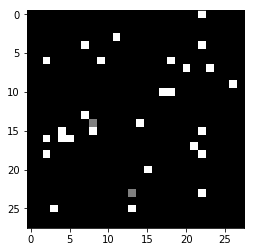

In [480]:
X=EncImages.eval(session=sess,feed_dict={x:temp1})
NewX = X[0]
#print (NewX)
for num, pixel in enumerate(X[0]):
    if pixel <=2e-1:
        #print (num)
        NewX[num] = 0
    elif pixel > 3e-1 and pixel <= 5e-1:
        NewX[num] = 0.5
        #print ('yes')
    else:
        NewX[num] = 1
TempImage = NewX.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()





In [481]:
X=EncImages.eval(session=sess,feed_dict={x:temp1})
print (X.shape)

(1, 784)
